<a href="https://colab.research.google.com/github/SouhailChatti/Tweet-Sentiment-Extraction/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Librairie Google Colab
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Monte votre Google Drive sur le serveur.
drive.mount("/content/MyDrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/MyDrive/


# ***Read Data***

In [0]:
Df_train = pd.read_csv('/content/MyDrive/My Drive/train.csv')
Df_test = pd.read_csv('/content/MyDrive/My Drive/test.csv')

In [0]:
Df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
Df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


# ***Exploratory Data Analysis (EDA)***

In [5]:
print(Df_train.info())
print(Df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB
None


In [6]:
print(Df_train.isna().sum())

# only 2 null values out of 24000 total values.
# let's drop them.

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [7]:
Df_test.isna().sum()

# No null values in test dataset.

textID       0
text         0
sentiment    0
dtype: int64

In [0]:
Df_train.dropna(inplace=True)

In [9]:
Df_train.isna().sum()

# No null values left.

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [10]:
#There are in total 27K training rows
Df_train.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [11]:
#There are in total 3.5K test rows
Df_test.sentiment.value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

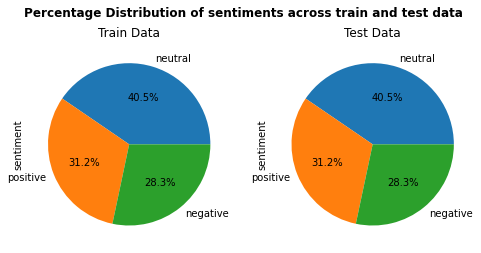

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

pd.value_counts(Df_train['sentiment']).plot(kind = 'pie', ax=ax1,autopct='%1.1f%%')
pd.value_counts(Df_test['sentiment']).plot(kind ='pie', ax=ax2,autopct='%1.1f%%')
ax1.set_title("Train Data")
ax2.set_title("Test Data")
plt.suptitle("Percentage Distribution of sentiments across train and test data",fontweight = "bold")
plt.show()

Nous constatons que les données de test ont exactement la même distribution que les données du train, ce qui m'a choqué, mais je l'ai revérifié. Les tweets neutres sont les plus nombreux (environ 41%), suivis des tweets positifs (envirion 31%) et les plus faibles des tweets négatifs (~28%)

In [0]:
Df_train.replace({"sentiment":{"positive":2, "neutral":1, "negative":0}}, inplace=True)
Df_test.replace({"sentiment":{"positive":2, "neutral":1, "negative":0}}, inplace=True)

In [14]:
Df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,088c60f138,my boss is bullying me...,bullying me,0
3,9642c003ef,what interview! leave me alone,leave me alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0


In [15]:
Df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1
1,96d74cb729,Shanghai is also really exciting (precisely -...,2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0
3,01082688c6,happy bday!,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2


In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

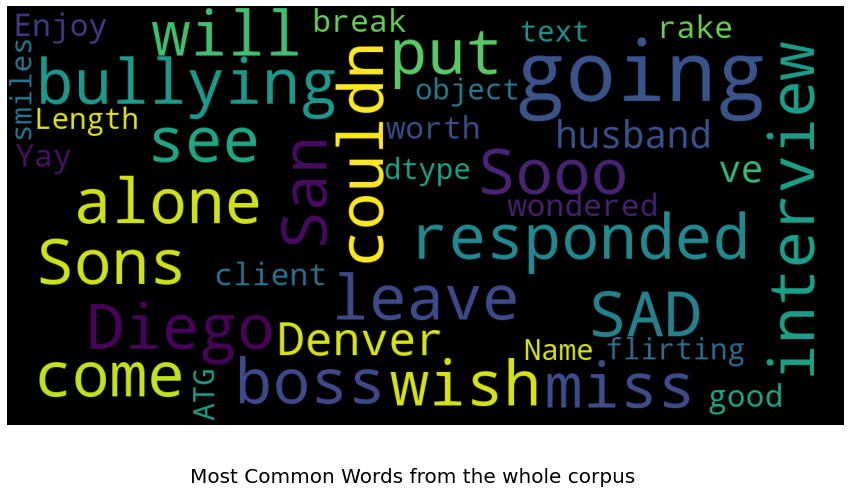

In [17]:
show_wordcloud(Df_train['text'],'Most Common Words from the whole corpus')

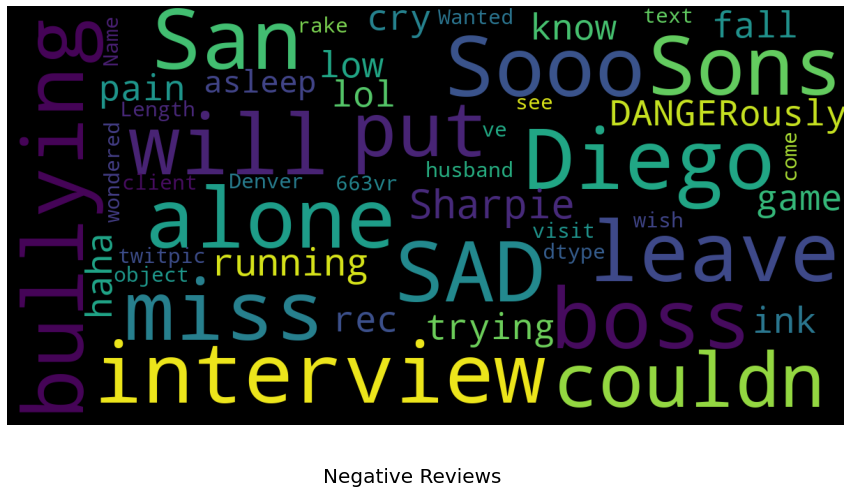

In [18]:
show_wordcloud(Df_train[Df_train['sentiment'] == 0]['text'],'Negative Reviews')

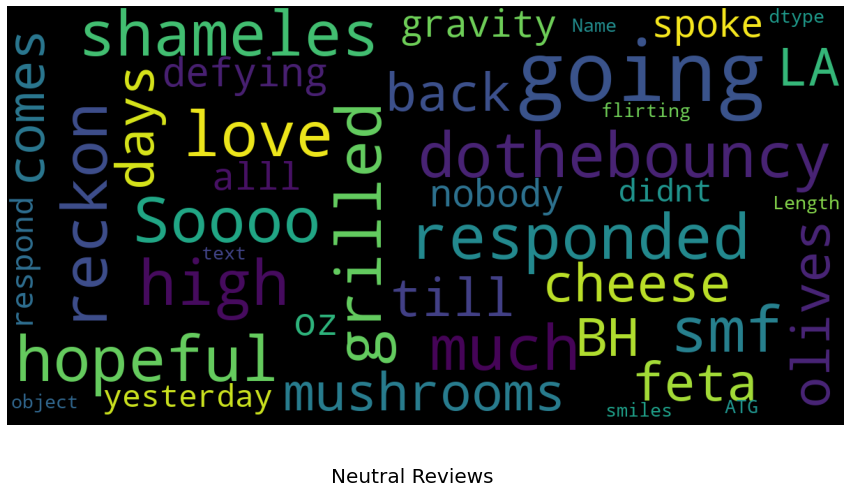

In [19]:
show_wordcloud(Df_train[Df_train['sentiment'] == 1]['text'],'Neutral Reviews')

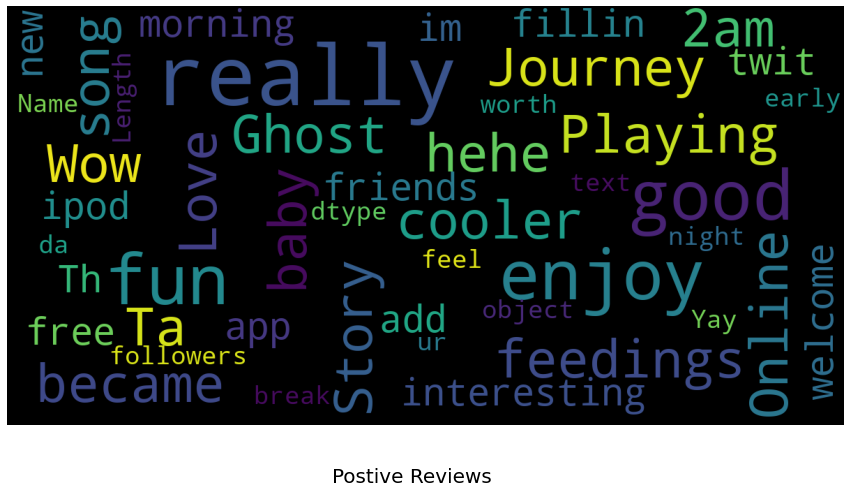

In [20]:
show_wordcloud(Df_train[Df_train['sentiment'] == 2]['text'],'Postive Reviews')

# ***Data Pre-processing***

In [0]:
Df_train['text'] = Df_train['text'].str.lower()
Df_train['text'] = Df_train['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',str(x))))

Df_test['text'] = Df_test['text'].str.lower()
Df_test['text'] = Df_test['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [0]:
X_train = Df_train.text
y_test=Df_test.sentiment
y_train = Df_train.sentiment
tokenize = Tokenizer()
tokenize.fit_on_texts(X_train.values)

In [0]:
X_test = Df_test.text

X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

In [0]:
max_lenght= max([len(s.split()) for s in Df_train['text']])
X_train = pad_sequences(X_train, max_lenght)
X_test = pad_sequences(X_test, max_lenght)

# ***Model building (LSTM)***

In [0]:
max_features = len(tokenize.word_index)+1
batch_size = 1000
epochs = 10
num_classes = 3

In [0]:
model_LSTM=Sequential()
model_LSTM.add(Embedding(max_features,100,input_length=max_lenght))
model_LSTM.add(LSTM(64,dropout=0.2,return_sequences=True))
model_LSTM.add(LSTM(32,dropout=0.3,return_sequences=False))
model_LSTM.add(Dense(num_classes,activation='softmax'))


In [27]:
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 100)           2872900   
_________________________________________________________________
lstm (LSTM)                  (None, 33, 64)            42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 2,927,655
Trainable params: 2,927,655
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
model_LSTM.fit(X_train, y_train,batch_size=batch_size, epochs=epochs,  verbose=1)

Epoch 1/10
28/28 [==============================] - 13s 453ms/step - loss: 1.0765 - accuracy: 0.4121
Epoch 2/10
28/28 [==============================] - 13s 451ms/step - loss: 0.9308 - accuracy: 0.5450
Epoch 3/10
28/28 [==============================] - 13s 455ms/step - loss: 0.7203 - accuracy: 0.6771
Epoch 4/10
28/28 [==============================] - 13s 461ms/step - loss: 0.5497 - accuracy: 0.7782
Epoch 5/10
28/28 [==============================] - 13s 455ms/step - loss: 0.4329 - accuracy: 0.8369
Epoch 6/10
28/28 [==============================] - 13s 454ms/step - loss: 0.3476 - accuracy: 0.8742
Epoch 7/10
28/28 [==============================] - 13s 455ms/step - loss: 0.2915 - accuracy: 0.8976
Epoch 8/10
28/28 [==============================] - 13s 454ms/step - loss: 0.2446 - accuracy: 0.9158
Epoch 9/10
28/28 [==============================] - 13s 454ms/step - loss: 0.2156 - accuracy: 0.9271
Epoch 10/10
28/28 [==============================] - 13s 451ms/step - loss: 0.1884 - accura

In [0]:
y_pred_train = model_LSTM.predict_classes(X_train)
y_pred_test = model_LSTM.predict_classes(X_test)

In [54]:
y_pred_final

array([1, 2, 0, ..., 0, 2, 1])

In [55]:
y_pred_LSTM  = model_LSTM.predict(X_test)
print(y_pred_LSTM)

[[3.1060932e-02 9.2302287e-01 4.5916218e-02]
 [6.0148694e-04 1.7185877e-03 9.9768001e-01]
 [9.7721171e-01 2.1843877e-02 9.4436394e-04]
 ...
 [9.9397391e-01 5.0143469e-03 1.0117458e-03]
 [1.8107323e-03 4.0213723e-02 9.5797557e-01]
 [6.3866857e-03 7.9373151e-01 1.9988182e-01]]


In [0]:
# Une fonction qui va nous permettre de mieux afficher la résultat de l'évaluation de notre modéle

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def print_score(label, prediction, train=True):
    if train:
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
    
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix
print_score(y_train, y_pred_train, train=True)
print_score(y_test, y_pred_test,train=False)

Train Result:
Accuracy Score: 95.83%
_______________________________________________
Confusion Matrix: 
 [[ 7390   343    48]
 [  230 10714   173]
 [   86   265  8231]]

Test Result:
Accuracy Score: 67.35%
_______________________________________________
Confusion Matrix: 
 [[656 310  35]
 [247 966 217]
 [ 57 288 758]]

